**变量名称说明**
- data 原始数据
- data_train 训练集，2-6月
- data_test 测试集，7 月

**数据处理步骤**
1. 基于月份将 training set 分为 train subset（2月至6月）和valid set（7月）
2. 使用 training/testing set 生成各项非用户特征
3. 通过用户 ID 匹配用户特征，若用户ID不存在则取中位数为变量赋值

In [1]:
import pandas as pd
import re
from math import isnan    
import numpy as np
import string
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
#import jieba
#import jieba.analyse

In [2]:
# data=pd.read_csv('weibo_train_data.txt',sep='\t',header=None)
# data.columns=['user_id','weibo_id','time','repost','comments','likes','text']
data=pd.read_csv('weibo_train_data_tfidf.txt',sep='\t')
data.columns=['user_id','weibo_id','time','repost',  'comments','likes', 'tfidf','text'] # for tf-idf dataset
data.head()

,user_id,weibo_id,time,repost,comments,likes,tfidf,text
0,d38e9bed5d98110dc2489d0d1cac3c2a,7d45833d9865727a88b960b0603c19f6,2015-02-23 17:41:29,0,0,0,2.516793,丽江旅游(sz002033)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...
1,fa13974743d3fe6ff40d21b872325e9e,8169f1d45051e08ef213bf1106b1225d,2015-02-14 12:49:58,0,0,0,1.260857,#丁辰灵的红包#挣钱是一种能力，抢红包拼的是技术。我抢到了丁辰灵 和@阚洪岩 一起发出的现金...
2,da534fe87e7a52777bee5c30573ed5fd,68cd0258c31c2c525f94febea2d9523b,2015-03-31 13:58:06,0,0,0,1.787769,淘宝网这些傻逼。。。气的劳资有火没地儿发~尼玛，你们都瞎了
3,e06a22b7e065e559a1f0bf7841a85c51,00b9f86b4915aedb7db943c54fd19d59,2015-06-11 20:39:57,0,4,3,2.988692,看点不能说的，你们都懂[笑cry]
4,f9828598f9664d4e347ef2048ce17734,c7f6f66044c0c5a3330e2c5371be6824,2015-03-10 18:02:38,0,0,0,5.977384,111多张


# 一、微博文本特征 by 陈永乔

In [3]:
#a. 微博原始长度
f = lambda x:len(str(x))
data['length_all']=data['text'].map(f)

In [4]:
#a. 微博中文长度
def count_chinese(text):
    text=str(text)
    num=0
    for s in text:
        if '\u4e00' <= s <= '\u9fff':
            num+=1
    return num
data['length_chinese']=data['text'].map(count_chinese)

In [5]:
#b. 是否为英文内容，字数一般以上是英文字母，则该微博是英文
def is_en(text):
    text=str(text)
    num=0
    for s in text:
        if s in string.ascii_letters:
            num+=1
    if num>len(text)*0.5:
        return 1
    else:
        return 0
    
data['english']=data['text'].map(is_en)

In [6]:
#b. 是否为非中文内容
def Non_ch(text):
    text=str(text)
    num=0
    for s in text:
        if '\u4e00' <= s <= '\u9fff':
            num+=1
    if num==0:
        return 1
    else:
        return 0
data['non_ch']=data['text'].map(Non_ch)

In [7]:
data.head()

,user_id,weibo_id,time,repost,comments,likes,tfidf,text,length_all,length_chinese,english,non_ch
0,d38e9bed5d98110dc2489d0d1cac3c2a,7d45833d9865727a88b960b0603c19f6,2015-02-23 17:41:29,0,0,0,2.516793,丽江旅游(sz002033)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...,62,30,0,0
1,fa13974743d3fe6ff40d21b872325e9e,8169f1d45051e08ef213bf1106b1225d,2015-02-14 12:49:58,0,0,0,1.260857,#丁辰灵的红包#挣钱是一种能力，抢红包拼的是技术。我抢到了丁辰灵 和@阚洪岩 一起发出的现金...,100,61,0,0
2,da534fe87e7a52777bee5c30573ed5fd,68cd0258c31c2c525f94febea2d9523b,2015-03-31 13:58:06,0,0,0,1.787769,淘宝网这些傻逼。。。气的劳资有火没地儿发~尼玛，你们都瞎了,29,24,0,0
3,e06a22b7e065e559a1f0bf7841a85c51,00b9f86b4915aedb7db943c54fd19d59,2015-06-11 20:39:57,0,4,3,2.988692,看点不能说的，你们都懂[笑cry],17,11,0,0
4,f9828598f9664d4e347ef2048ce17734,c7f6f66044c0c5a3330e2c5371be6824,2015-03-10 18:02:38,0,0,0,5.977384,111多张,5,2,0,0


In [8]:
#d.是否为分享
def is_sharing(text):
    text=str(text)
    if re.findall(r'分享',text,re.I):
        return 1
    if re.findall(r'推荐',text,re.I):
        return 1
    return 0
data['sharing']=data['text'].map(is_sharing)

In [9]:
#e. 是否为回复自动发博(文本中包含'我...了'和'@'或网页链接)
def is_auto(text):
    text_1=str(text)
    text=np.array(list(str(text)))
    flag_1=0  #是否包含'我...了'
    flag_2=0  #是否包含'@'
    flag_3=0  #是否包含http
    if re.findall(r'我.+了',text_1,re.I):
        flag_1=1   
    if re.findall(r'@',text_1,re.I):
        flag_2=1    
    if re.findall(r'http',text_1,re.I):
        flag_3=1
    if flag_1*(flag_2+flag_3)>=1:
        return 1
    else:
        return 0
data['auto']=data['text'].map(is_auto)

In [10]:
#f. 是否为互动内容（是否包含'//'，但要考虑网页链接中的'//'）
def is_interaction(text):
    text=str(text)
    num_1=len(re.findall(r'//',text,re.I))
    num_2=len(re.findall(r'http',text,re.I))
    if num_1>num_2:
        return 1
    else:
        return 0
data['interaction']=data['text'].map(is_interaction)

In [11]:
#g. 是否包含书名号《》
def is_book(text):
    text=str(text)
    if re.findall(r'《.+》',text,re.I):
        return 1
    else:
        return 0
data['book']=data['text'].map(is_book)

In [12]:
#h. 是否包含@
def is_mention(text):
    text=str(text)
    if re.findall(r'@',text,re.I):
        return 1
    else:
        return 0
data['mention']=data['text'].map(is_mention)

In [13]:
#i. 是否包含投票
def is_vote(text):
    text=str(text)
    if re.findall(r'投票',text,re.I):
        return 1
    else:
        return 0
data['vote']=data['text'].map(is_vote)

In [14]:
#j. 是否包含抽奖
def is_lottery(text):
    text=str(text)
    if re.findall(r'抽[奖到中]',text,re.I):
        return 1
    if re.findall(r'[奖礼]品',text,re.I):
        return 1
    if re.findall(r'[好大]礼',text,re.I):
        return 1
    if re.findall(r'[赢领]取',text,re.I):
        return 1
    return 0
data['lottery']=data['text'].map(is_lottery)

In [15]:
#k. 是否包含表情
def is_emoji(text):
    text=str(text)
    if re.findall(r'\[.+\]',text,re.I):
        return 1
    else:
        return 0
data['emoji']=data['text'].map(is_emoji)

In [16]:
#L.是否包含视频
def is_video(text):
    text=str(text)
    if re.findall(r'【视频',text,re.I):
        return 1
    return 0
data['video']=data['text'].map(is_video)

In [17]:
#M.是否包含链接
def is_http(text):
    text=str(text)
    if re.findall(r'http',text,re.I):
        return 1
    return 0
data['http']=data['text'].map(is_http)

In [18]:
#是否股票推文
def is_stock(text):
    text=str(text)
    if re.findall(r'股票',text,re.I):
        return 1
    if re.findall(r'炒股',text,re.I):
        return 1
    return 0
data['stock']=data['text'].map(is_stock)

# 二、微博文本特征 by 欧阳

In [19]:
# n. 是否存在第三方平台互动消息（“我在#xxx”）
data['app'] = data.text.apply(lambda x: 1 if '我' in str(x) else 0) # str to convert string in numbers into strings

In [20]:
# o. 是否包含【】/是否有标题（很可能是新闻）
data['title'] = data.text.apply(lambda x: 1 if str(x)[0] == '【' else 0) 

In [21]:
# q. 是否包含广告
ad_keywords = ['天猫', '淘宝', '京东','当当','唯品会','唯品会','红包','购物券', '折扣', '优惠']
data['ad'] = data.text.apply(lambda x: 1 if any( keyword in str(x) for keyword in ad_keywords) else 0) # list generator

In [22]:
# r. 是否包含百度热词
baidu_hot_words = ['2015阅兵', '奔跑吧兄弟', '花干骨', 'duang', 'DUANG', '毕福剑', '完美世界', '清华大学', '九寨沟', '天津爆炸', '快乐大本营', \
                   '校花的贴身高手', '车震', '金星', '大主宰', '武汉大学', '泰山', '全面开放二孩政策', 'running man','Running Man','Running man',\
                   'RUNNING MAN', '盗墓笔记', '萌萌哒', '王思聪', '淘宝', '厦门大学', '颐和园', '优衣库事件', '最强大脑', '何以笙箫默', '然并卵', \
                   '叶良辰', '百度', '北京大学', '故宫', '毕福剑违纪', '极限挑战', '斗鱼', '有钱就是任性', '昆凌', '我欲封天', '中山大学', '华山', \
                   'a股保卫战','A股保卫战', '欢乐喜剧人', '琅琊榜', '不做死就不会死', '刘雯', '双色球开奖结果', '中南大学', '北戴河', '人民币贬值', \
                   '天天向上', '克拉恋人', '小鲜肉', '章泽天', 'qq', 'QQ', '复旦大学', '普陀山', '2015苹果发布会', '中国好声音', '旋风少年', '绿茶婊', \
                   '马云', '微信', '山东大学', '五台山', '另一个地球可能发现', '康熙来了', '终极教师', '壕', '宁泽涛', '花千骨', '浙江大学', '峨眉山', \
                   '日本8.5级地震', '奇葩说', '武媚娘传奇', '我也是醉了', '柴静', '双色球', '西南大学', '云台山']
data['hotwords'] = data.text.apply(lambda x: 1 if any( keyword in str(x) for keyword in baidu_hot_words) else 0) # list generator

In [23]:
# t.jieba 分词，寻找高频热词，查看每条微博是否包含高频热词
#import jieba
#import jieba.analyse
#threshold = 5
#content = data[(data['repost'] > threshold) & (data['comments'] > threshold) & (data['likes'] > threshold)]['text'].to_string( index = False, header = False)
##jieba.analyse.set_stop_words('stoped.txt') # do not remove any meaningless words for 1st model 
#keywords = jieba.analyse.extract_tags(content, topK=500)
keywords = ["...", "http", "cn", "分享", "程序员", "doge", "##", "一个", "10", "2015", "教程", "Python", "RAIN", "微博", "Java", "PS", "大家", "cry", "rain", "设计", "今天", "克拉", "恋人", "Rain", "Android", "学习", "JIHOON", "微软", "Linux", "开源", "代码", "技术", "设计师", "哈哈", "UI", "网站", "技巧", "文章", "开发", "推荐", "iOS", "我们", "编程", "Windows", "如何", "慕课", "郑智薰", "可以", "数据", "视频", "这个", "Web", "自己", "阿里", "算法", "JavaScript", "转发", "早安", "20", "Photoshop", "....", "方法", "同学", "最近", "什么", "知乎", "PHP", "前端", "使用", "小伙伴", "百度", "手机", "公司", "很多", "用户", "15", "知道", "Google", "黑客", "中国", "App", "就是", "看到", "福利", "问题", "互联网", "下载", "开发者", "时候", "现在", "作者", "程序", "机器", "工程师", "团队", "来自", "发布", "拜拜", "安全", "为什么", "工作", "工具", "30", "MySQL", "一下", "腾讯", "朋友", "面试", "偷笑", "趣图", "喜欢", "软件", "系统", "一些", "字体", "已经", "如果", "不是", "觉得", "简单", "框架", "小编", "13", "应用", "HTML5", "C++", "没有", "非常", "图标", "CSS", "网络", "粉丝", "关于", "图片", "生日快乐", "发现", "微信", "你们", "午间", "怎么", "一组", "免费", "招聘", "介绍", "语言", "晚安", "需要", "还是", "网页", "本文", "编程语言", "项目", "开始", "移动", "入门", "创意", "漏洞", "嘻嘻", "利用", "这么", "手把手", "课程", "支付宝", "真的", "实现", "总结", "效果", "2014", "Git", "动画", "数据库", "指南", "创业", "优化", "照片", "世界", "感觉", "素材", "深度", "12", "浏览器", "photoshop", "基于", "论文", "应该", "系列", "Data", "一篇", "有个", "GitHub", "实用", "在线", "北京", "灵感", "Learning", "可视化", "平台", "Logo", "不要", "看看", "翻译", "动图", "11", "Swift", "这样", "游戏", "优秀", "分析", "其实", "终于", "服务器", "360", "苹果", "真是", "感谢", "内存", "产品", "因为", "谷歌", "性能", "那些", "更新", "新手", "干货", "Apple", "支持", "广告", "25", "Studio", "架构", "时间", "测试", "js", "别人", "各种", "有人", "老师", "快速", "打包", "出来", "电脑", "Mac", "web", "服务", "打造", "优设", "博客", "这些", "全文", "good", "童鞋", "篇文章", "一张", "制作", "版本", "人生", "JS", "100", "一种", "他们", "每日", "那么", "不能", "每天", "美国", "但是", "经典", "昨天", "一直", "配色", "Build", "Chrome", "com", "呵呵", "然后", "几个", "插件", "Rain625", "PPT", "作品", "评论", "出道", "周年", "上线", "基础", "体验", "汇总", "Machine", "详解", "正式", "思考", "计算机", "绘制", "关注", "大学", "地址", "攻击", "一起", "所有", "发表", "微博上", "APP", "插画", "实践", "周末", "大会", "图灵", "武汉", "一样", "围观", "ht", "14", "Facebook", "Spark", "居然", "这是", "为了", "不会", "海报", "知识", "功能", "东西", "htt", "作为", "通过", "下面", "一定", "欢迎", "资源", "整理", "信息", "可爱", "新浪", "科技", "18", "动效", "可能", "实战", "了解", "电影", "比较", "理解", "客户端", "CSS3", "之前", "哈哈哈", "收到", "各位", "妹子", "爬虫", "运维", "同事", "视觉", "讨论", "希望", "进阶", "有趣", "一次", "红包", "全球", "起来", "页面", "手绘", "故事", "本书", "神器", "简历", "SQL", "Deep", "老板", "欣赏", "源码", "生活", "经常", "最后", "每个", "一天", "据说", "哪些", "Go", "Visual", "计算", "抓狂", "多少", "不错", "事情", "网友", "一位", "处理", "阿里巴巴", "两个", "大哥", "以前", "最佳", "一款", "内容", "官方", "国外", "最好", "个人", "遇到", "交互", "孩子", "50", "极客", "科学", "面试题", "佳佳", "译者", "时代", "16", "Twitter", "bug", "HTTP", "宣布", "强大", "小米", "还有", "特别", "回答", "常用", "最新", "有没有", "超赞", "小时", "携程", "经验", "必备", "员工", "3D", "iPhone", "里面", "搜索", "活动", "界面", "地图", "几天", "SAE", "抽奖", "人类", "是不是", "分钟", "原理", "研究", "排序", "记得", "get", "app", "淘宝", "成为", "晚上", "数据分析", "国内", "朋友圈", "只有", "今年", "逗比", "萧亮", "C语言", "文件", "越来越", "未来", "完成", "这里", "亲们", "17", "海报设计", "GIF", "QQ", "Docker", "简直", "模板", "大全", "键盘", "这次", "成功", "花心", "第一", "创建", "专业", "IE", "男神", "CEO", "安卓", "选择", "怎样", "搞定", "一年", "模型", "告诉", "重要", "所以", "联合", "提供", "社交", "HTML", "AI", "API", "建议", "解析"]
data['keywords'] = data.text.apply(lambda x: 1 if any( keyword in str(x) for keyword in keywords) else 0) # list generator

In [24]:
data.head()

,user_id,weibo_id,time,repost,comments,likes,tfidf,text,length_all,length_chinese,...,lottery,emoji,video,http,stock,app,title,ad,hotwords,keywords
0,d38e9bed5d98110dc2489d0d1cac3c2a,7d45833d9865727a88b960b0603c19f6,2015-02-23 17:41:29,0,0,0,2.516793,丽江旅游(sz002033)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...,62,30,...,0,0,0,0,1,0,0,0,0,1
1,fa13974743d3fe6ff40d21b872325e9e,8169f1d45051e08ef213bf1106b1225d,2015-02-14 12:49:58,0,0,0,1.260857,#丁辰灵的红包#挣钱是一种能力，抢红包拼的是技术。我抢到了丁辰灵 和@阚洪岩 一起发出的现金...,100,61,...,0,0,0,1,0,1,0,1,0,1
2,da534fe87e7a52777bee5c30573ed5fd,68cd0258c31c2c525f94febea2d9523b,2015-03-31 13:58:06,0,0,0,1.787769,淘宝网这些傻逼。。。气的劳资有火没地儿发~尼玛，你们都瞎了,29,24,...,0,0,0,0,0,0,0,1,1,1
3,e06a22b7e065e559a1f0bf7841a85c51,00b9f86b4915aedb7db943c54fd19d59,2015-06-11 20:39:57,0,4,3,2.988692,看点不能说的，你们都懂[笑cry],17,11,...,0,1,0,0,0,0,0,0,0,1
4,f9828598f9664d4e347ef2048ce17734,c7f6f66044c0c5a3330e2c5371be6824,2015-03-10 18:02:38,0,0,0,5.977384,111多张,5,2,...,0,0,0,0,0,0,0,0,0,1


# 三、用户的时间特征 by 武妍戎

1. 是否周中，是否周末  
2. 是否节假日  
3. 发文时间段（需要结合数据再最后确定）  
4. 工作日与节假日可能存在交互效应（作息不同）  

In [25]:
def process_time(data):
    data['time_date']=data['time'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").date())
###求星期几
    data['time_weekday']=data['time_date'].apply(lambda x: x.weekday())+1
    data['time_weekend1']=((data['time_weekday']==6))
    data['time_weekend2']=((data['time_weekday']==7))
    #data['time_weekend']=(data.loc[1,'time_weekend1'])or(data.loc[1,'time_weekend2'])
    ###计算是否为周末
    data['time_weekend']=pd.DataFrame({'time_weekend':list(map(lambda x, y: 1 if x|y else 0, data['time_weekend1'],data['time_weekend2']))})
###求发博时间段，由于作息不同，故时间段有交叉
    data['time_hour']=data['time'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").hour)
    data.loc[data.apply(lambda data:(data['time_hour']>=1)and(data['time_hour']<7), axis=1), 'panduan']=1   
    data.loc[data.apply(lambda data:(data['time_hour']>=7)and(data['time_hour']<12), axis=1), 'panduan']=2
    data.loc[data.apply(lambda data:(data['time_hour']>=12)and(data['time_hour']<18), axis=1), 'panduan']=3 
    data.loc[data.apply(lambda data:(data['time_hour']>=18)and(data['time_hour']<24) or (data['time_hour']==0), axis=1), 'panduan']=4
    data.drop(['time_date','time_weekend1','time_weekend2'],axis=1, inplace=True)
    return data
#ID 日期 index为0和-1 次数 24哑变量

In [26]:
data= process_time(data)
data.head(2)

,user_id,weibo_id,time,repost,comments,likes,tfidf,text,length_all,length_chinese,...,stock,app,title,ad,hotwords,keywords,time_weekday,time_weekend,time_hour,panduan
0,d38e9bed5d98110dc2489d0d1cac3c2a,7d45833d9865727a88b960b0603c19f6,2015-02-23 17:41:29,0,0,0,2.516793,丽江旅游(sz002033)#股票##炒股##财经##理财##投资#推荐包赢股，盈利对半分成...,62,30,...,1,0,0,0,0,1,1,0,17,3.0
1,fa13974743d3fe6ff40d21b872325e9e,8169f1d45051e08ef213bf1106b1225d,2015-02-14 12:49:58,0,0,0,1.260857,#丁辰灵的红包#挣钱是一种能力，抢红包拼的是技术。我抢到了丁辰灵 和@阚洪岩 一起发出的现金...,100,61,...,0,1,0,1,0,1,6,1,12,3.0


# 四、划分训练集和测试集
因为用户特征不能从测试集提取，故先划分出来

In [39]:
data['month']=data['time'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").month) # 原始数据

# training set // Feb. to Jun.
data_train = data[data['month']<=6]
data_train.reset_index(inplace = True)
data_train.drop(['month', 'index'],axis=1,inplace=True)
#data_train.head()

# testing set // Jul.
data_test = data[data['month']==7]
data_test.reset_index(inplace = True)
data_test.drop(['month', 'index'],axis=1,inplace=True)
data_test.head()

,user_id,weibo_id,time,repost,comments,likes,tfidf,text,length_all,length_chinese,...,stock,app,title,ad,hotwords,keywords,time_weekday,time_weekend,time_hour,panduan
0,f349a67d1cd7c8683c5bbc5f8486e193,83674a60e5310195fc35d97ea8f45c46,2015-07-15 01:16:24,0,0,0,1.390068,论优衣库试衣间隔音效果好坏？ http://t.cn/RL5aSzp（分享自 @知乎）,43,18,...,0,0,0,0,0,1,3,0,1,1.0
1,875a4a77b339d93f819e2c4de5bd0b57,f2cdcdbcec9ff47cbb3c6a636e4b92a3,2015-07-01 04:11:48,0,0,0,0.731223,#IT#【武汉一专车司机因毒驾被治安拘留】新华网武汉6月29日电(记者冯国栋)记者28日从武...,102,66,...,0,0,0,0,0,1,3,0,4,1.0
2,0fc17bf5e2dc789dd48505df1f5b14fd,4c1e2418127811d212d0e3867a99db3e,2015-07-13 05:07:28,0,0,1,2.988692,羽田机场~~ http://t.cn/RLGJidL,26,4,...,0,0,0,0,0,1,1,0,5,1.0
3,dd749a5af07c04ce7de451273a983671,419dd71d562883ef836e774bc3f4e163,2015-07-30 14:24:28,0,0,0,0.962645,"分享了-KUTLUK-的歌单《Piano,奏响灵魂深处...》 http://t.cn/...",64,19,...,0,0,0,0,0,1,4,0,14,3.0
4,6623347e5f19f35f2d02ad515b96524c,9a2f48a870843d1964a03c6642b309d5,2015-07-21 01:06:53,0,0,0,1.018777,#糟蹋酒鬼菜#老板每次推荐完他们家的下酒菜，就会拼命的安利上等的酒……我每次都会妥协的喝两罐汽水。,49,43,...,0,1,0,0,0,1,2,0,1,1.0


# 五、 微博的用户特征 by 刘安蕾

1. 历史数据的 range（最大值和最小值）, 平均值和方差，大于平均值的次数。
2. 在训练集中出现的次数（发博频率）
3. 在训练集中收获转发的最高次数（估计粉丝量水平） 

In [40]:
def process_max(data):
    
    ###求训练集中出现的次数
    df_processnum=data['repost'].groupby(data['user_id']).agg('count')
    data['number_in_train']=data['user_id'].apply(lambda x:df_processnum[str(x)])
    
    ###求最大值
    df_processmax=data.groupby('user_id').agg({'repost':np.max,'comments':np.max,'likes':np.max})
#    print (df_processmax.columns)
    df_processmax.columns=['forward_max','comment_max','like_max']
    df_processmax.reset_index(inplace = True)
    data =pd.merge(data, df_processmax, on=['user_id']).fillna(0)
    
    ###求最小值
    df_processmin=data.groupby('user_id').agg({'repost':np.min,'comments':np.min,'likes':np.min})
    df_processmin.columns=['forward_min','comment_min','like_min']
    df_processmin.reset_index(inplace = True)
    data =pd.merge(data, df_processmin, on=['user_id']).fillna(0)
    
    ####求平均值
    df_processmean=data.groupby('user_id').agg({'repost':np.mean,'comments':np.mean,'likes':np.mean})
    df_processmean.columns=['forward_mean','comment_mean','like_mean']
    df_processmean.reset_index(inplace = True)
    data =pd.merge(data, df_processmean, on=['user_id']).fillna(0)
    
    #####求某一用户发的微博互动大于平均值的概率
    daa=pd.DataFrame({'user_id':data['user_id'].value_counts()})
    daa.reset_index(inplace=True)
    daa.columns=['user_id','count']
    
    ###统计大于平均值的发博次数
    forward_ave=np.mean(data['repost'])
    comment_ave=np.mean(data['comments'])
    like_ave=np.mean(data['likes'])
#    print (forward_ave,comment_ave,like_ave)
    data['forward_judge']=data['repost'].apply(lambda x:1 if x>forward_ave else 0)
    data['comment_judge']=data['comments'].apply(lambda x:1 if x>comment_ave else 0)
    data['like_judge']=data['likes'].apply(lambda x:1 if x>like_ave else 0)
    more_ave=data.groupby('user_id').agg({'forward_judge':np.sum,'comment_judge':np.sum,'like_judge':np.sum})
    more_ave.columns=['forward_more_ave','comment_more_ave','like_more_ave']
    more_ave.reset_index(inplace = True)
    data.drop(['forward_judge','comment_judge','like_judge'],axis=1, inplace=True)
    daa =pd.merge(more_ave, daa, on=['user_id'])
    daa['forward_more_ave_pr']=daa['forward_more_ave']/daa['count']
    daa['comment_more_ave_pr']=daa['comment_more_ave']/daa['count']
    daa['like_more_ave_pr']=daa['like_more_ave']/daa['count']
    daa.drop(['forward_more_ave','comment_more_ave','like_more_ave','count'],axis=1, inplace=True)
    data =pd.merge(data, daa, on=['user_id']).fillna(0)  
    data['max_f/l']=pd.DataFrame({'max_f/l':list(map(lambda x, y: x/y if y>0 else 0, data['forward_max'],data['like_max']))})
    data['max_c/l']=pd.DataFrame({'max_c/l':list(map(lambda x, y: x/y if y>0 else 0, data['comment_max'],data['like_max']))})
    data['min_f/l']=pd.DataFrame({'min_f/l':list(map(lambda x, y: x/y if y>0 else 0, data['forward_min'],data['like_min']))})
    data['min_c/l']=pd.DataFrame({'min_c/l':list(map(lambda x, y: x/y if y>0 else 0, data['comment_min'],data['like_min']))})
    data['mean_f/l']=pd.DataFrame({'mean_f/l':list(map(lambda x, y: x/y if y>0 else 0, data['forward_mean'],data['like_mean']))})
    data['mean_c/l']=pd.DataFrame({'mean_c/l':list(map(lambda x, y: x/y if y>0 else 0, data['comment_mean'],data['like_mean']))}) 
    return data

In [41]:
# 先对 training set 进行用户特征提取
data_train = process_max(data_train)

C:\Users\oyrx\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [42]:
# 对两个集 column names 求差集，更方便
missing_columns = ['user_id'] + list(set(data_train.columns).difference(set(data_test.columns)))
# 合并变量
data_test = pd.merge(data_test, data_train[missing_columns].drop_duplicates("user_id"), on = "user_id", how = 'left')

In [43]:
data_test.columns

Index(['user_id', 'weibo_id', 'time', 'repost', 'comments', 'likes', 'tfidf',
       'text', 'length_all', 'length_chinese', 'english', 'non_ch', 'sharing',
       'auto', 'interaction', 'book', 'mention', 'vote', 'lottery', 'emoji',
       'video', 'http', 'stock', 'app', 'title', 'ad', 'hotwords', 'keywords',
       'time_weekday', 'time_weekend', 'time_hour', 'panduan', 'forward_min',
       'like_min', 'like_mean', 'min_f/l', 'number_in_train',
       'forward_more_ave_pr', 'comment_max', 'forward_mean', 'max_f/l',
       'like_max', 'comment_more_ave_pr', 'like_more_ave_pr', 'comment_mean',
       'max_c/l', 'mean_f/l', 'mean_c/l', 'comment_min', 'forward_max',
       'min_c/l'],
      dtype='object')

In [44]:
data_test.head()

,user_id,weibo_id,time,repost,comments,likes,tfidf,text,length_all,length_chinese,...,like_max,comment_more_ave_pr,like_more_ave_pr,comment_mean,max_c/l,mean_f/l,mean_c/l,comment_min,forward_max,min_c/l
0,f349a67d1cd7c8683c5bbc5f8486e193,83674a60e5310195fc35d97ea8f45c46,2015-07-15 01:16:24,0,0,0,1.390068,论优衣库试衣间隔音效果好坏？ http://t.cn/RL5aSzp（分享自 @知乎）,43,18,...,2.0,0.125000,0.000000,0.818182,9.500000,0.500000,3.272727,0.0,4.0,0.0
1,875a4a77b339d93f819e2c4de5bd0b57,f2cdcdbcec9ff47cbb3c6a636e4b92a3,2015-07-01 04:11:48,0,0,0,0.731223,#IT#【武汉一专车司机因毒驾被治安拘留】新华网武汉6月29日电(记者冯国栋)记者28日从武...,102,66,...,10.0,0.000112,0.000223,0.003606,0.200000,1.112840,0.377432,0.0,11.0,0.0
2,0fc17bf5e2dc789dd48505df1f5b14fd,4c1e2418127811d212d0e3867a99db3e,2015-07-13 05:07:28,0,0,1,2.988692,羽田机场~~ http://t.cn/RLGJidL,26,4,...,1.0,0.142857,0.000000,0.333333,2.000000,0.000000,7.000000,0.0,0.0,0.0
3,dd749a5af07c04ce7de451273a983671,419dd71d562883ef836e774bc3f4e163,2015-07-30 14:24:28,0,0,0,0.962645,"分享了-KUTLUK-的歌单《Piano,奏响灵魂深处...》 http://t.cn/...",64,19,...,3.0,0.126316,0.021053,0.405263,2.333333,0.270270,2.081081,0.0,4.0,0.0
4,6623347e5f19f35f2d02ad515b96524c,9a2f48a870843d1964a03c6642b309d5,2015-07-21 01:06:53,0,0,0,1.018777,#糟蹋酒鬼菜#老板每次推荐完他们家的下酒菜，就会拼命的安利上等的酒……我每次都会妥协的喝两罐汽水。,49,43,...,4.0,0.114519,0.010225,0.435583,2.750000,2.038835,2.067961,0.0,23.0,0.0


In [45]:
data.to_csv('data.csv')
data_test.to_csv('data_test.csv')
data_train.to_csv('data_train.csv')

# 五、数据分析——武妍戎、刘安蕾

In [52]:
#用户特征描述性统计
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#不同点赞、评论、转发数的微博数分布
#转发数为1，2，3.。。的微博个数
data1=data.groupby(['repost']).size()
data1=data1.reset_index()
data1.columns=['forward_count','count']
print (data1.head())

   forward_count    count
0              0  1005745
1              1    77348
2              2    31415
3              3    18198
4              4    12083


Text(0.5, 1.0, 'forward_count')

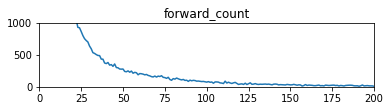

In [53]:
plt.subplot(3,1,1)
plt.axis([0,200,0,1000])
plt.plot(data1['forward_count'],data1['count'])
plt.title('forward_count')
#print (data1.info())

   like_count   count
0           0  917453
1           1  126172
2           2   55991
3           3   30530
4           4   19227


Text(0.5, 1.0, 'like_count')

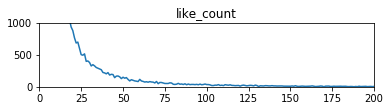

In [54]:
##点赞数为1，2，3.。。的微博个数
data2=data.groupby(['likes']).size()
data2=data2.reset_index()
data2.columns=['like_count','count']
print (data2.head())
plt.subplot(3,1,2)
plt.axis([0,200,0,1000])
plt.plot(data2['like_count'],data2['count'])
plt.title('like_count')

   comments_count   count
0               0  972026
1               1   83059
2               2   51624
3               3   27468
4               4   20262


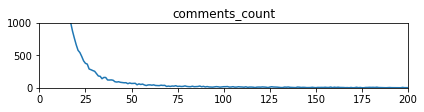

In [55]:
##评论数为1，2，3.。。的微博个数
data3=data.groupby(['comments']).size()
data3=data3.reset_index()
data3.columns=['comments_count','count']
print (data3.head())
plt.subplot(3,1,3)
plt.axis([0,200,0,1000])
plt.plot(data3['comments_count'],data3['count'])
plt.title('comments_count')
plt.tight_layout() 
plt.show()

In [56]:
data['forward_count']=data1['forward_count']
data['like_count']=data2['like_count']
data['comments_count']=data3['comments_count']

Text(0.5, 1.0, 'weibo_count in weekhour')

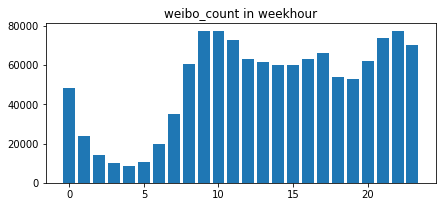

In [122]:
#发博时间
#周一-周日的发博次数
data=data.loc[:,['time_weekday','forward_count','like_count','comment_count']]
data1=data.groupby(['time_weekday']).size()
data1=data1.reset_index()
data1.columns=['time_weekday','count']
plt.figure(figsize=(7, 10), facecolor='#FFFFFF')
plt.subplot(3,1,1)
plt.bar(data1['time_weekday'],data1['count'])
plt.title('weibo_count in weekday') 

Text(0.5, 1.0, 'like_count in weekhour')

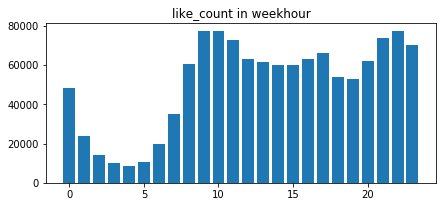

In [151]:
#发博时间
#1点-24点的发博点赞数
data=data.loc[:,['time_hour','forward_count','like_count','comment_count']]
data1=data.groupby(['time_hour']).size()
data1=data1.reset_index()
data1.columns=['time_hour','like_count']
plt.figure(figsize=(7, 10), facecolor='#FFFFFF')
plt.subplot(3,1,1)
plt.bar(data1['time_hour'],data1['like_count'])
plt.title('like_count in weekhour') 

Text(0.5, 1.0, 'forward_count in weekhour')

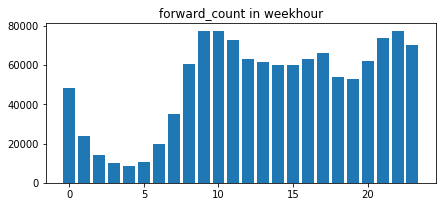

In [180]:
#发博时间
#1点-24点的发博转发数
data=data.loc[:,['time_hour','forward_count','like_count','comment_count']]
data1=data.groupby(['time_hour']).size()
data1=data1.reset_index()
data1.columns=['time_hour','forward_count']
plt.figure(figsize=(7, 10), facecolor='#FFFFFF')
plt.subplot(3,1,1)
plt.bar(data1['time_hour'],data1['forward_count'])
plt.title('forward_count in weekhour') 

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Text(0.5, 1.0, 'comment_count in weekhour')

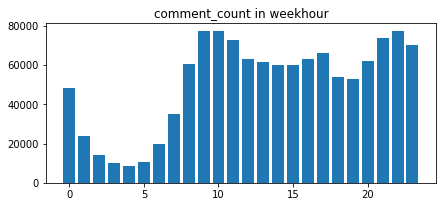

In [28]:
#发博时间
#1点-24点的发博评论数
data=data.loc[:,['time_hour','forward_count','like_count','comment_count']]
data1=data.groupby(['time_hour']).size()
data1=data1.reset_index()
data1.columns=['time_hour','comment_count']
plt.figure(figsize=(7, 10), facecolor='#FFFFFF')
plt.subplot(3,1,1)
plt.bar(data1['time_hour'],data1['comment_count'])
plt.title('comment_count in weekhour') 

Text(0.5, 1.0, 'weibo_count in weekday')

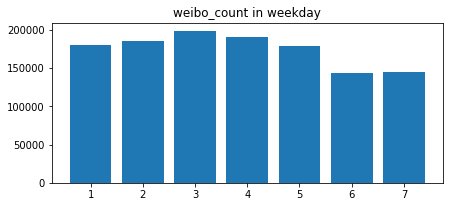

In [61]:
#发博时间
#周一-周日的发博次数
data=data.loc[:,['time_weekday','forward_count','like_count','comment_count']]
data1=data.groupby(['time_weekday']).size()
data1=data1.reset_index()
data1.columns=['time_weekday','count']
plt.figure(figsize=(7, 10), facecolor='#FFFFFF')
plt.subplot(3,1,1)
plt.bar(data1['time_weekday'],data1['count'])
plt.title('weibo_count in weekday') 

   time_weekday  forward_mean  comment_mean   like_mean
0             1   1218.457447           NaN  845.451064
1             2   1032.128571           NaN  802.360656
2             3   1367.670732           NaN  825.794118
3             4   1342.059211           NaN  889.895652
4             5   1394.134884           NaN  886.860465
5             6    919.925620           NaN  820.704762
6             7   1525.239521           NaN  804.165414


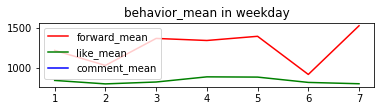

In [30]:
#周一-周日的发博的点赞中位数，平均值
data2=data.groupby(['time_weekday']).agg({'forward_count':np.mean,'comment_count':np.mean,'like_count':np.mean})
data2=data2.reset_index()
data2.columns=['time_weekday','forward_mean','comment_mean','like_mean']
print (data2)
plt.subplot(3,1,2)
plt.plot(data2['time_weekday'],data2['forward_mean'],label='forward_mean',color='red')
plt.plot(data2['time_weekday'],data2['like_mean'],label='like_mean',color='green')
plt.plot(data2['time_weekday'],data2['comment_mean'],label='comment_mean',color='blue')
plt.title('behavior_mean in weekday')  
plt.legend()

   forward_mean  count
0      0.000000  25259
1      0.000649      1
2      0.001117      1
3      0.001318      1
4      0.001883      1


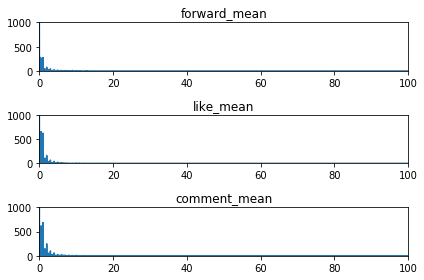

In [57]:
#用户特征描述性统计（补）
## 用户平均的点赞、评论、转发数的用户频数分布
data=data.drop_duplicates(['user_id'])
data=data.loc[:,['user_id','forward_mean','comment_mean','like_mean']]
data1=data.groupby(['forward_mean']).size()
data1=data1.reset_index()
data1.columns=['forward_mean','count']
print (data1.head())
plt.subplot(3,1,1)
plt.axis([0,100,0,1000])
plt.plot(data1['forward_mean'],data1['count'])
plt.title('forward_mean')   

data2=data.groupby(['like_mean']).size()
data2=data2.reset_index()
data2.columns=['like_mean','count']
plt.subplot(3,1,2)
plt.axis([0,100,0,1000])
plt.plot(data2['like_mean'],data2['count'])
plt.title('like_mean')   

data3=data.groupby(['comment_mean']).size()
data3=data3.reset_index()
data3.columns=['comment_mean','count'] 
plt.subplot(3,1,3)
plt.axis([0,100,0,1000])
plt.plot(data3['comment_mean'],data3['count'])
plt.title('comment_mean')  
plt.tight_layout() 
plt.show()

   forward_max  count
0          0.0  25297
1          1.0   4681
2          2.0   1663
3          3.0    875
4          4.0    509


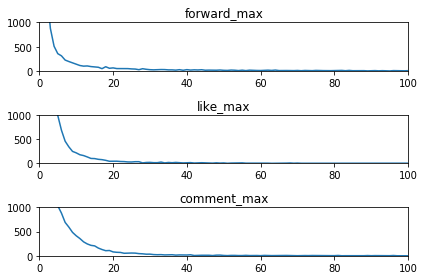

In [8]:
#用户特征描述性统计（补）
## 用户最大的点赞、评论、转发数的用户频数分布
data=data.drop_duplicates(['user_id'])
data=data.loc[:,['user_id','forward_max','comment_max','like_max']]
data1=data.groupby(['forward_max']).size()
data1=data1.reset_index()
data1.columns=['forward_max','count']
print (data1.head())
plt.subplot(3,1,1)
plt.axis([0,100,0,1000])
plt.plot(data1['forward_max'],data1['count'])
plt.title('forward_max')   

data2=data.groupby(['like_max']).size()
data2=data2.reset_index()
data2.columns=['like_max','count']
plt.subplot(3,1,2)
plt.axis([0,100,0,1000])
plt.plot(data2['like_max'],data2['count'])
plt.title('like_max')   

data3=data.groupby(['comment_max']).size()
data3=data3.reset_index()
data3.columns=['comment_max','count'] 
plt.subplot(3,1,3)
plt.axis([0,100,0,1000])
plt.plot(data3['comment_max'],data3['count'])
plt.title('comment_max')  
plt.tight_layout() 
plt.show()

In [ ]:
#文本特征描述性统计，代码部分没跑通，用了别人的图，可Excel调整美观性
##主题、链接、@、表情的影响
data=train_data.loc[:,['topic','http','@','emotion','forward_count','like_count','comment_count']]
#主题
data1=data.groupby(['topic']).agg({'forward_count':np.mean,'comment_count':np.mean,'like_count':np.mean})
data1=data1.reset_index()
data1.columns=['topic','forward_mean','comment_mean','like_mean']
#print (data1[data1['topic']==0])
name_list=['forward_mean','comment_mean','like_mean']
x=list(range(3))
total_width, n = 0.8, 2
width = total_width / n   
data11=list(data1[data1['topic']==0].loc[0,['forward_mean','comment_mean','like_mean']])
print (data11)
plt.figure(figsize=(7, 10), facecolor='#FFFFFF')
plt.subplot(4,1,1)
plt.bar(x,data11,width=width, label='0',fc = 'y')
for i in range(3):
    x[i] = x[i] + width
data11=list(data1[data1['topic']==1].loc[1,['forward_mean','comment_mean','like_mean']])
#print (data11)
plt.bar(x,data11, width=width, label='1',tick_label = name_list,fc = 'r')  
plt.title('topic and behavior')   
#链接
data1=data.groupby(['http']).agg({'forward_count':np.mean,'comment_count':np.mean,'like_count':np.mean})
data1=data1.reset_index()
data1.columns=['http','forward_mean','comment_mean','like_mean']
#print (data1[data1['http']==0])
name_list=['forward_mean','comment_mean','like_mean']
x=list(range(3))
total_width, n = 0.8, 2
width = total_width / n   
data11=list(data1[data1['http']==0].loc[0,['forward_mean','comment_mean','like_mean']])
print (data11)
plt.subplot(4,1,2)
plt.bar(x,data11,width=width, label='0',fc = 'y')
for i in range(3):
    x[i] = x[i] + width
data11=list(data1[data1['http']==1].loc[1,['forward_mean','comment_mean','like_mean']])
#print (data11)
plt.bar(x,data11, width=width, label='1',tick_label = name_list,fc = 'r')  
plt.title('http and behavior')
#@
data1=data.groupby(['@']).agg({'forward_count':np.mean,'comment_count':np.mean,'like_count':np.mean})
data1=data1.reset_index()
data1.columns=['@','forward_mean','comment_mean','like_mean']
#print (data1[data1['http']==0])
name_list=['forward_mean','comment_mean','like_mean']
x=list(range(3))
total_width, n = 0.8, 2
width = total_width / n   
data11=list(data1[data1['@']==0].loc[0,['forward_mean','comment_mean','like_mean']])
print (data11)
plt.subplot(4,1,3)
plt.bar(x,data11,width=width, label='0',fc = 'y')
for i in range(3):
    x[i] = x[i] + width
data11=list(data1[data1['@']==1].loc[1,['forward_mean','comment_mean','like_mean']])
#print (data11)
plt.bar(x,data11, width=width, label='1',tick_label = name_list,fc = 'r')  
plt.title('@ and behavior')

#emotion
data1=data.groupby(['emotion']).agg({'forward_count':np.mean,'comment_count':np.mean,'like_count':np.mean})
data1=data1.reset_index()
data1.columns=['emotion','forward_mean','comment_mean','like_mean']
#print (data1[data1['http']==0])
name_list=['forward_mean','comment_mean','like_mean']
x=list(range(3))
total_width, n = 0.8, 2
width = total_width / n   
data11=list(data1[data1['emotion']==0].loc[0,['forward_mean','comment_mean','like_mean']])
print (data11)
plt.subplot(4,1,4)
plt.bar(x,data11,width=width, label='0',fc = 'y')
for i in range(3):
    x[i] = x[i] + width
data11=list(data1[data1['emotion']==1].loc[1,['forward_mean','comment_mean','like_mean']])
#print (data11)
plt.bar(x,data11, width=width, label='1',tick_label = name_list,fc = 'r')  
plt.title('emotion and behavior')
plt.legend()
plt.tight_layout() 
plt.savefig("./plot/主题、链接、@、表情的影响.jpg")
plt.show()
#注：此段代码需单列出来跑，否则上面data会有影响